# Model Arima pour la prédiction du nombre d'articles vendus journaliers

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [43]:
df = pd.read_csv("sales_processed") 
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


In [44]:
df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,revenue
date,,,,,,,,,
2013-01-02,0,59,21788,0.063406,1.0,2,1,2013,-0.029076
2013-01-03,0,25,2495,0.005519,1.0,3,1,2013,-0.046658
2013-01-06,0,25,2497,0.474434,1.0,6,1,2013,0.095765
2013-01-15,0,25,2498,0.121293,1.0,15,1,2013,-0.011494
2013-01-10,0,25,2507,-0.312861,1.0,10,1,2013,-0.143358
...,...,...,...,...,...,...,...,...,...
2015-10-10,33,25,7263,-0.341805,1.0,10,10,2015,-0.152149
2015-10-09,33,25,7314,-0.341805,1.0,9,10,2015,-0.152149
2015-10-14,33,25,7313,-0.312861,1.0,14,10,2015,-0.143358


Grouper les données par date pour réduire le nombre de lignes du dataset, dans le cas contraire avec toutes les données, l'entrainement du model prend beaucoup de temps

In [45]:
sales_data = df.groupby('date').sum()['item_cnt_day']

In [46]:
sales_data

,item_cnt_day
date,
2013-01-01,1957.0
2013-01-02,8232.0
2013-01-03,7444.0
2013-01-04,6628.0
2013-01-05,6360.0
...,...
2015-10-27,1555.0
2015-10-28,3599.0
2015-10-29,1591.0


**Rééchantillonner les données de ventes à une fréquence journalière et remplir les éventuelles valeurs manquantes avec 0.**

In [47]:
daily_sales_data = sales_data.asfreq('D').fillna(0)

Diviser les données en train et test set:

In [48]:
split_idx = int(len(daily_sales_data) * 0.8)
train_sales = daily_sales_data[:split_idx]
test_sales = daily_sales_data[split_idx:]


In [49]:
train_sales.tail()

,item_cnt_day
date,
2015-04-03,2304.0
2015-04-04,3823.0
2015-04-05,3054.0
2015-04-06,1969.0
2015-04-07,1911.0


In [50]:
train_sales.head()

,item_cnt_day
date,
2013-01-01,1957.0
2013-01-02,8232.0
2013-01-03,7444.0
2013-01-04,6628.0
2013-01-05,6360.0


In [51]:
test_sales.head()

,item_cnt_day
date,
2015-04-08,1858.0
2015-04-09,1714.0
2015-04-10,2146.0
2015-04-11,3214.0
2015-04-12,2304.0


**Etude de la stationnarité de la série temporelle**

In [52]:
from statsmodels.tsa.stattools import adfuller

In [53]:
# Appliquer le test Dickey-Fuller Augmenté
result = adfuller(daily_sales_data)

print("Statistique ADF :", result[0])
print("p-value :", result[1])
print("Valeurs critiques :", result[4])

if result[1] <= 0.05:
    print("La série est stationnaire.")
else:
    print("La série n'est pas stationnaire.")


Statistique ADF : -4.041558375025963
p-value : 0.0012078700027100585
Valeurs critiques : {'1%': -3.436828225807217, '5%': -2.8644002004847144, '10%': -2.568292900881126}
La série est stationnaire.


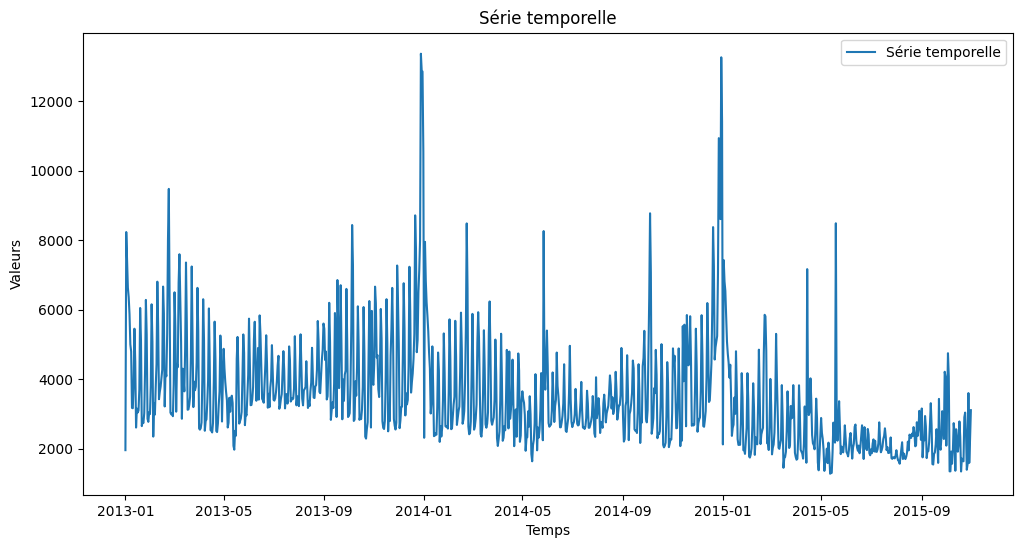

In [54]:
import matplotlib.pyplot as plt

# Tracer la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_data, label="Série temporelle")
plt.title("Série temporelle")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.legend()
plt.show()


Les résultats indiquent que la série est stationnaire, mais nous allons quand meme faire une différenciation

In [55]:
sales_stationnaires = daily_sales_data.diff()

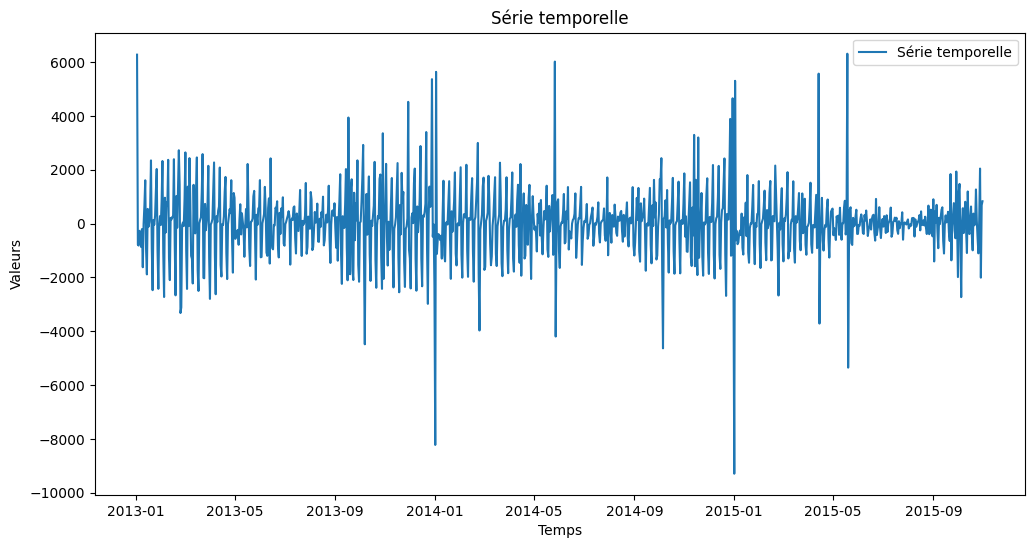

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sales_stationnaires, label="Série temporelle")
plt.title("Série temporelle")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.legend()
plt.show()

Visuellement, la série semble plus stationnaire, on gardera ça pour le model

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

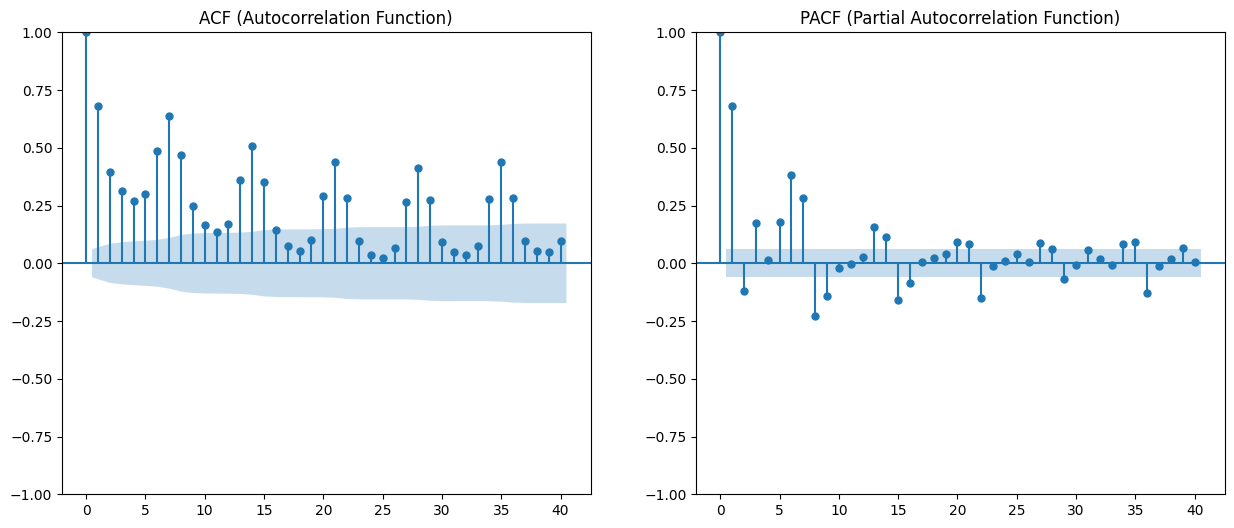

In [58]:
# Tracer ACF et PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ACF
plot_acf(daily_sales_data, ax=axes[0], lags=40) 
axes[0].set_title("ACF (Autocorrelation Function)")

# PACF
plot_pacf(daily_sales_data, ax=axes[1], lags=40, method="ywm")  
axes[1].set_title("PACF (Partial Autocorrelation Function)")

plt.show()


Les barres de l'ACF décroissent progressivement et restent significatives jusqu'à environ le lag 5-6.

Cela suggère que les termes de moyenne mobile (
𝑞
q) sont importants jusqu'au lag 2-3 ou davantage.

Le modèle nécessite probablement
𝑞
=
2 ou
𝑞
=
3, car les lags au-delà deviennent moins significatifs.


Les barres de la PACF chutent fortement après le lag 2, avec des barres significatives au lag 1 et au lag 2, mais faibles au-delà.

Cela suggère qu'il y a un effet autorégressif important jusqu'au lag 2 et 4.

Le modèle nécessite probablement
𝑝
=
2,3,4 car les lags au-delà de 4 ne sont plus significatifs.

Comme la série est stationnaire, il n'y a pas un besoin de faire une différence. Donc d=0

Tester avec p=2, d=1 et q=2:

In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Entraîner le modèle ARIMA sur les données différenciées
model = ARIMA(train_sales, order=(2,1, 2))
model_fit = model.fit()

# Résumé
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                  827
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7040.990
Date:                Sat, 30 Nov 2024   AIC                          14091.980
Time:                        19:42:44   BIC                          14115.563
Sample:                    01-01-2013   HQIC                         14101.026
                         - 04-07-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3564      0.011    -32.330      0.000      -0.378      -0.335
ar.L2          0.6436      0.006    109.045      0.000       0.632       0.655
ma.L1      -5.404e-05      1.324  -4.08e-05      1.0

In [60]:
forecast = model_fit.forecast(steps=len(test_sales))

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculer les scores
rmse = np.sqrt(mean_squared_error(test_sales, forecast))
mae = mean_absolute_error(test_sales, forecast)          
mape = np.mean(np.abs((test_sales - forecast) / test_sales)) * 100  
mbe = np.mean(test_sales - forecast)                     
r2 = r2_score(test_sales, forecast)                      

# Afficher les résultats
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"MBE (Mean Bias Error): {mbe:.2f}")
print(f"R² (Coefficient of Determination): {r2:.2f}")


RMSE (Root Mean Squared Error): 1737.83
MAE (Mean Absolute Error): 1637.01
MAPE (Mean Absolute Percentage Error): 82.18%
MBE (Mean Bias Error): -1540.27
R² (Coefficient of Determination): -3.74


In [62]:
test_sales.mean()

2279.4975845410627

In [63]:
test_sales.max()

8484.0

**Interprétation des résultats**

Avec un RMSE élevé (1737.83), un MAE important (1637.01), un MAPE inacceptable (82 %), et un MBE négatif significatif (-1540.27), le modèle ARIMA actuel n’est pas performant pour prédire cette série temporelle.
Ces résultats montrent que le modèle n’explique pas bien la variance des données, qu’il sous-prédit les ventes, et qu’il nécessite des ajustements ou des transformations.


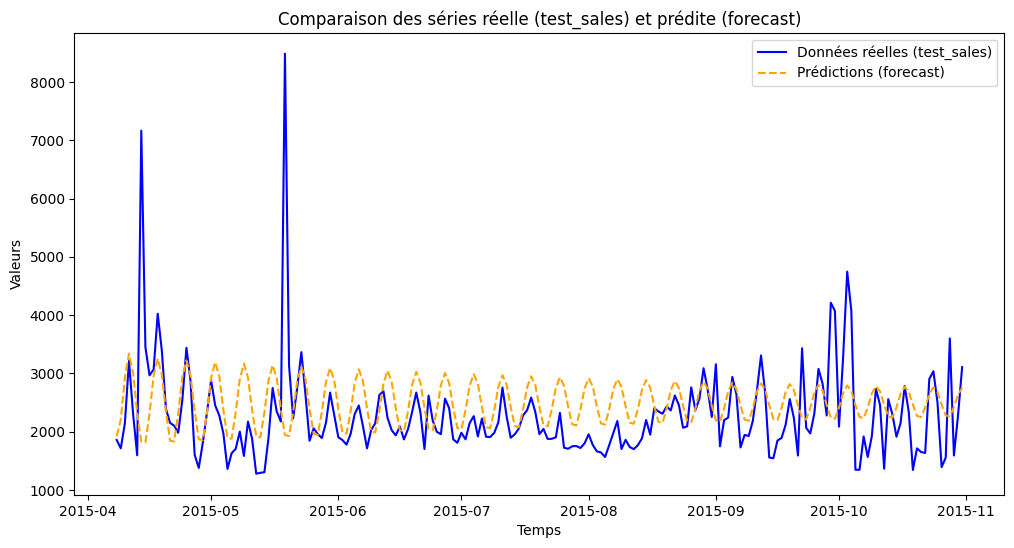

In [30]:
import matplotlib.pyplot as plt

# Tracer les séries test_sales (réelles) et forecast (prédite)
plt.figure(figsize=(12, 6))


plt.plot(test_sales.index, test_sales, label="Données réelles (test_sales)", color="blue")


plt.plot(test_sales.index, forecast, label="Prédictions (forecast)", color="orange", linestyle="--")


plt.title("Comparaison des séries réelle (test_sales) et prédite (forecast)")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.legend()
plt.show()


Nous allons essayer d'améliorer nos résultats en cherchant automatiquement les meilleurs valeurs p,d et q

In [69]:
from pmdarima import auto_arima
model = auto_arima(train_sales, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.order)  # Meilleurs paramètres ARIMA (p, d, q)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14027.436, Time=9.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14240.046, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14242.238, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14241.995, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14238.046, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14014.355, Time=4.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14021.358, Time=1.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14080.505, Time=5.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14015.986, Time=5.58 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14014.063, Time=0.75 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=14015.864, Time=0.96 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=14015.654, Time=1.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=14012.203, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14021.467, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0

In [73]:
from statsmodels.tsa.arima.model import ARIMA

# Entraîner le modèle ARIMA sur les données différenciées
model2 = ARIMA(train_sales, order=(0,1, 3))
model_fit2 = model2.fit()
forecast2 = model_fit2.forecast(steps=len(test_sales))

# Calculer les scores
rmse = np.sqrt(mean_squared_error(test_sales, forecast2))  # Root Mean Squared Error
mae = mean_absolute_error(test_sales, forecast2)          # Mean Absolute Error
mape = np.mean(np.abs((test_sales - forecast2) / test_sales)) * 100  # Mean Absolute Percentage Error
mbe = np.mean(test_sales - forecast2)                     # Mean Bias Error
r2 = r2_score(test_sales, forecast2)                      # R² Score

# Afficher les résultats
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"MBE (Mean Bias Error): {mbe:.2f}")


RMSE (Root Mean Squared Error): 827.78
MAE (Mean Absolute Error): 581.94
MAPE (Mean Absolute Percentage Error): 27.25%
MBE (Mean Bias Error): -219.83


**Interprétation des résultats**

Le RMSE indique une erreur moyenne quadratique en unités absolues.
Si la moyenne des ventes réelles est autour de 2279.50 (comme mentionné précédemment), le RMSE représente environ 36.3 % de la moyenne.
Cela indique que, bien que l'erreur soit encore significative, elle est plus faible que les résultats précédents (RMSE de 1737.83).
Le modèle est donc modérément amélioré par rapport aux précédentes itérations, mais les erreurs restent importantes.

Le MAE est l’erreur absolue moyenne, qui est moins sensible aux grandes erreurs que le RMSE.
Un MAE de 581.94 est bien plus faible que la moyenne des ventes (2279.50), représentant environ 25.5 % de la moyenne.
Cela signifie que, pour chaque prédiction, l’écart moyen par rapport à la valeur réelle est relativement modéré

Le MAPE indique une erreur moyenne en pourcentage des valeurs réelles. Avec un MAPE de 27.25 %, les prédictions s’écartent en moyenne de 27 % par rapport aux valeurs réelles.
Interprétation qualitative :

MAPE < 10 % : Excellent.
10 % < MAPE < 20 % : Bon.
20 % < MAPE < 50 % : Acceptable.
MAPE > 50 % : Mauvais.

Un MAPE de 27.25 % est considéré comme acceptable, mais il montre que le modèle peut encore être amélioré pour réduire davantage l’erreur.

Le MBE mesure le biais moyen des prédictions. Un MBE négatif de -219.83 indique que le modèle a une légère tendance à sous-prédire les valeurs réelles.
Cependant, l’ampleur du biais est relativement faible comparée à la moyenne des ventes (2279.50). Cela suggère que le modèle est globalement bien équilibré, même s'il peut encore être légèrement ajusté.

Afin de mieux améliorer le model, nous allons chercher s'il y a une saisonnalité dans notre série

**Recherche de saisonnalité**

1. A partir des graphiques acf et pacf:

1. Analyse de l'ACF (Autocorrelation Function)
Observation des lags multiples :

Il y a des pics significatifs aux lags 7, 14, 21, 28, etc.
Cela suggère une périodicité hebdomadaire (saisonnière), car ces lags correspondent à des multiples de 7, ce qui peut indiquer un comportement cyclique récurrent sur une base hebdomadaire.

Interprétation :

La présence de ces pics confirme qu'il y a probablement un motif saisonnier avec une période de 7 jours dans nos données.
Ces motifs peuvent être liés à un comportement hebdomadaire (par exemple, variations des ventes selon les jours de la semaine).

2. Analyse de la PACF (Partial Autocorrelation Function)
Observation des lags significatifs :

Les lags 1, 2 et 7 sont significatifs.
Cela indique que la série a un effet autorégressif marqué à ces lags.
Interprétation :

Un p (termes autorégressifs) de 1 ou 2 serait un bon point de départ.
La saisonnalité observée à lag 7 suggère que la composante saisonnière (

P) pourrait être également incluse dans le modèle avec une période saisonnière (
𝑠
=
7).

Les graphiques ACF et PACF confirment la présence de saisonnalité hebdomadaire avec une période approximative de 7 jours. Cela signifie que nous devrions envisager un modèle SARIMA pour capturer cette composante saisonnière.

# Modèle SARIMA:

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


sarima_model = SARIMAX(train_sales,
                       order=(2, 1, 2),             # Paramètres non saisonniers
                       seasonal_order=(1, 1, 1, 7), # Paramètres saisonniers
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()

# Résumé du modèle
print(sarima_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                        item_cnt_day   No. Observations:                  827
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -6626.880
Date:                             Sat, 30 Nov 2024   AIC                          13267.760
Time:                                     20:15:53   BIC                          13300.631
Sample:                                 01-01-2013   HQIC                         13280.381
                                      - 04-07-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       2.222e-05      0.248   8.97e-05      1.000      -0.485       0.485
ar.L2          0.3946      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE : 986.92


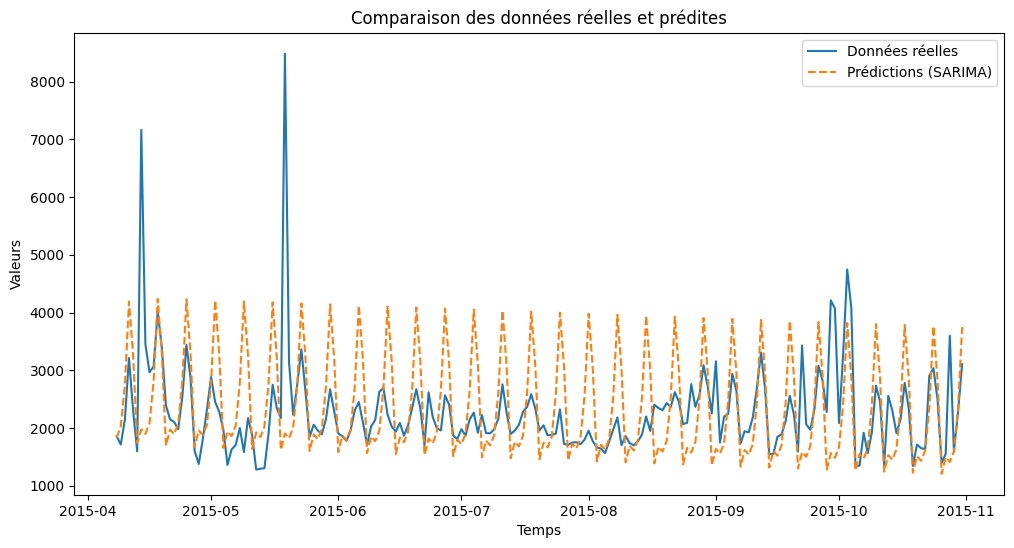

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Prédictions sur les données de test
forecast = sarima_fit.forecast(steps=len(test_sales))

# Calcul du RMSE
rmse = np.sqrt(mean_squared_error(test_sales, forecast))
print(f"RMSE : {rmse:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_sales.index, test_sales, label="Données réelles")
plt.plot(test_sales.index, forecast, label="Prédictions (SARIMA)", linestyle="--")
plt.title("Comparaison des données réelles et prédites")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.legend()
plt.show()


Recherche automatique des paramètres du model SARIMA

In [77]:
from pmdarima import auto_arima

# Rechercher les meilleurs paramètres SARIMA
auto_sarima = auto_arima(daily_sales_data,
                         seasonal=True,
                         m=7,  # Période saisonnière
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True)

# Afficher les paramètres optimaux
print(auto_sarima.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=8.03 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17700.759, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17367.642, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17481.816, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17698.760, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17700.244, Time=0.16 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17267.597, Time=1.19 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=17103.364, Time=2.84 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17088.090, Time=1.76 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=17503.917, Time=0.62 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=17208.651, Time=3.96 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=17420.765, Time=2.70 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=4.12 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=17131.062, Time=1.64 sec
 ARIMA(2,1,0)(1,0,1)[7] interce

Nous allons maintenant tester le model avec ces paramètres trouvés

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajuster le modèle SARIMA(0,1,4)(1,0,1)[7]
sarima_model2 = SARIMAX(train_sales,
                       order=(0, 1, 4),             # Non saisonnier
                       seasonal_order=(1, 0, 1, 7), # Saisonnier
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit2 = sarima_model2.fit()

# Résumé du modèle
print(sarima_fit2.summary())


                                      SARIMAX Results                                      
Dep. Variable:                        item_cnt_day   No. Observations:                  827
Model:             SARIMAX(0, 1, 4)x(1, 0, [1], 7)   Log Likelihood               -6721.164
Date:                             Sat, 30 Nov 2024   AIC                          13456.328
Time:                                     20:22:32   BIC                          13489.242
Sample:                                 01-01-2013   HQIC                         13468.962
                                      - 04-07-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4145      0.038    -10.804      0.000      -0.490      -0.339
ma.L2          0.0352      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE : 934.98


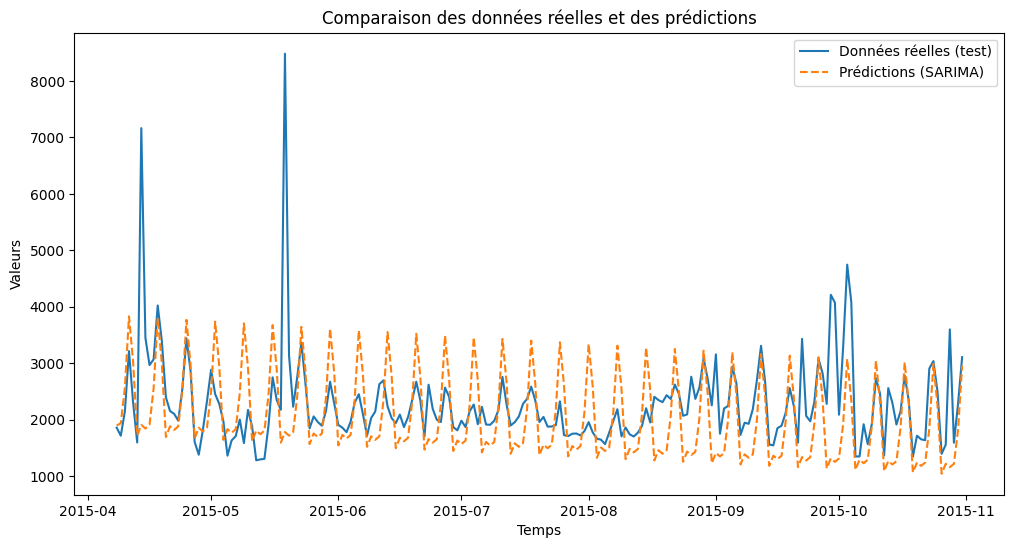

In [81]:
# Prédire sur l'ensemble de test
forecast = sarima_fit2.forecast(steps=len(test_sales))

# Calculer le RMSE pour évaluer le modèle
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_sales, forecast))
print(f"RMSE : {rmse:.2f}")

# Tracer les prédictions et les valeurs réelles
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_sales.index, test_sales, label="Données réelles (test)")
plt.plot(test_sales.index, forecast, label="Prédictions (SARIMA)", linestyle="--")
plt.title("Comparaison des données réelles et des prédictions")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.legend()
plt.show()


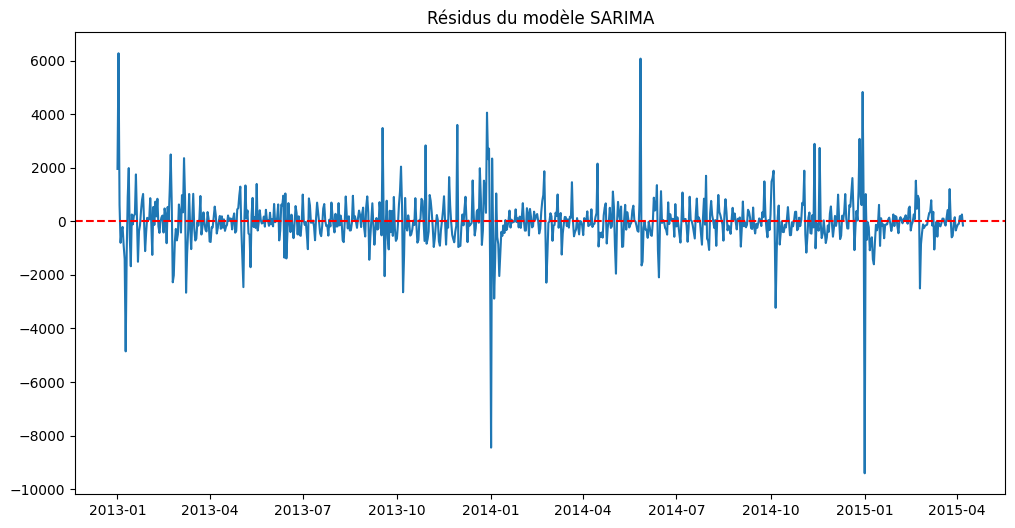

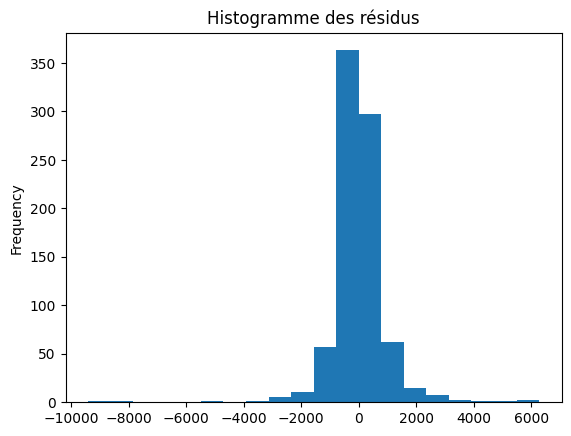

In [82]:
# Tracer les résidus
residuals = sarima_fit2.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("Résidus du modèle SARIMA")
plt.axhline(0, linestyle="--", color="red")
plt.show()

# Histogramme des résidus
residuals.plot(kind='hist', bins=20, title="Histogramme des résidus")
plt.show()


**Observations :**
Les résidus oscillent autour de zéro (ligne rouge), ce qui est une bonne chose.
Cependant, il y a des pics extrêmes à certains moments, où les résidus dépassent largement les valeurs normales, indiquant que le modèle ne capture pas parfaitement ces variations.
La distribution semble globalement stable, mais il existe des périodes où les variations sont plus importantes.

**Interprétation :**
Point positif : Le fait que les résidus soient centrés autour de zéro suggère que le modèle n’a pas de biais systématique dans ses prédictions.
Point négatif : Les pics extrêmes montrent que le modèle a des difficultés à prédire certains événements inhabituels dans les données. Ces événements peuvent être des anomalies ou des comportements non saisonniers que le modèle n’a pas capturés.


**Conclusion**

Le modèle SARIMA(0,1,4)(1,0,1)[7] offre une bonne performance générale, mais présente des limites pour capturer des variations extrêmes ou des comportements inhabituels.